# Ch7 - Hypothesis and Inference

The *science* part of data science frequently involves forming and testing hypotheses about data and the processes that generate it.

## Statistical Hypothesis Testing

Often we want to test whether a certain hypothesis (assertions like “this coin is fair” or “data scientists prefer Python to R” that can be translated into statistics about data) is likely to be true. 

*Under various assumptions*, those statistics can be thought of as **observations of random variables from known distributions**, which allows us to make statements about how likely those assumptions are to hold.

In the classical setup, we have a null hypothesis `H0` that represents some default position, and some alternative hypothesis `H1` that we’d like to compare it with, and we use statistics to decide whether we can reject `H0` as false or not, or fail to reject `H0`.

#### Example: Flipping a Coin
Imagine we have a coin to test if it’s fair. Make the assumption
that the coin has some probability p of landing heads, so our `H0` = the
coin is fair — that is, that `p = .5` . We’ll test this against the alternative hypothesis, `p != .5`

In particular, our test will involve flipping the coin some number `n` times and counting the number of heads `X`. *Each coin flip is a Bernoulli trial*, which means that `X` = a *Binomial(n,p) random variable*, which we can approximate using the Gaussian distribution:



In [1]:
import math

def normal_approx_to_binomial(n,p):
    """Find mu and sigma corresponding to 
    a Binomial(n,p) random variable"""
    mu = n*p
    sigma = math.sqrt(n*p*(1-p))
    return mu, sigma

print(normal_approx_to_binomial(10000,.5))
print(normal_approx_to_binomial(10000,.8))
print(normal_approx_to_binomial(10000,.2))

(5000.0, 50.0)
(8000.0, 39.99999999999999)
(2000.0, 40.0)


Whenever a random variable follows a normal distribution, we can use `normal_cdf()` to figure out the probability its realized value lies within (or outside) a particular interval:

In [2]:
## Normal/Gaussian CDF = probability the variable is BELOW a threshold
def normal_cdf(x,mu=0,sigma=1):
    return (1+math.erf((x-mu)/math.sqrt(2)/sigma))/2
normal_prob_below = normal_cdf

# it is ABOVE threshold if it's NOT BELOW threshold
def normal_prob_above(lo,mu=0,sigma=1):
    return 1 - normal_cdf(lo,mu,sigma)

# it is WITHIN if it's LESS THAN HI + MORE THAN LO
def normal_prob_between(lo,hi,mu=0,sigma=1):
    return normal_cdf(hi,mu,sigma) - normal_cdf(lo,mu,sigma)

# it is OUTSIDE if it's BETWEEN HI AND LOW
def normal_prob_outside(lo,hi,mu=0,sigma=1):
    return 1 - normal_prob_between(lo,hi,mu,sigma)

We can also do the reverse == *find either the nontail region or the (symmetric) interval around the mean that accounts for a certain level of likelihood*. 

For example, to find an interval centered at the mean + containing 60% probability, then we find the cutoffs where the upper and lower tails each contain 20% of the probability (leaving 60%):

In [3]:
def inverse_normal_cdf(p,mu=0,sigma=1,tolerance=.00001):
    """Find the approximate inverse using binary search"""
    
    # if not standard, standardize and re-scale
    if mu != 0 or sigma != 1:
        return mu + sigma*inverse_normal_cdf(p,tolerance=tolerance)
    
    low_z, low_p = -10.0, 0  # normal_cdf(-10) = very close to 0
    hi_z, hi_p = 10.0, 1     # normal_cdf(10) = very close to 1
    
    while hi_z - low_z > tolerance: 
        mid_z = (low_z + hi_z) / 2 # consider midpoint
        mid_p = normal_cdf(mid_z)  # and the CDF's value there
        
        if mid_p < p:
            # if midpoint is still too low, search above it
            low_z, low_p = mid_z, mid_p
        elif mid_p > p:
            # if midpoint is still too high, search below it
            hi_z, hi_p = mid_z, mid_p 
        else:
            break
    
    return mid_z

def normal_upper_bound(p,mu=0,sigma=1):
    """Return the z for which P(Z <= z) = given p"""
    return inverse_normal_cdf(p,mu,sigma)

def normal_lower_bound(p,mu=0,sigma=1):
    """Return the z for which P(Z >= z) = given p"""
    return inverse_normal_cdf(1-p,mu,sigma)

def normal_two_sided_bounds(p,mu=0,sigma=1):
    """Returns symmetric (about the mean) interval
    that contains given p"""
    tail_probability = (1-p)/2
    
    # upper bound = tail probability value above it
    upper_bound = normal_lower_bound(tail_probability,mu,sigma)
    
    # lower bound = tail probability value below it
    lower_bound = normal_upper_bound(tail_probability,mu,sigma)
    
    return lower_bound,upper_bound

Let's say we choose to flip `n=100` times. If `H0` is true, then `X` should be distributed approximately normally with mean 50 and SD 15.8

In [4]:
mu_0, sigma_0 = normal_approx_to_binomial(1000,.5)
print(mu_0, sigma_0)

500.0 15.811388300841896


Now, we need to make a decision about **significance** — how willing we are to make a **type 1 error (“false positive”, or FP)**, in which we reject `H0` even though it’s true. This willingness is often set at 5% or 1%.

Consider the test that rejects if X falls outside the bounds given by:

In [5]:
# 5% significance level
normal_two_sided_bounds(.95,mu_0,sigma_0)

(469.01026640487555, 530.9897335951244)

Assuming `p` *really* equals 0.5 (i.e., `H0` is true), there is just a 5% chance we observe an `X` that lies outside this interval, `(469,531)`, which is the *exact* significance we wanted. 

Said differently, if `H0` is true, then, approximately 19 times out of 20, this test will give the correct result.

We are also often interested in **power** of a test = **the probability of not making a type 2 error ("false negative", or FN) = fail to reject `H0` even though it’s false**. 

To measure this, we must specify *exactly* what "`H0` being false" means. (merely knowing p is *not* 0.5 doesn’t give a ton of info about the distribution of `X`). 

In particular, let’s check what happens if p is *actually* 0.55, so that the coin is slightly biased toward heads. In that case, we can calculate the power of the test with:

In [6]:
# 95% bounds based on assumption that p=.5 (coin is fair)
lo,hi = normal_two_sided_bounds(.95,mu_0,sigma_0)

# actual mu + sigma based on p=.55
mu_1, sigma_1 = normal_approx_to_binomial(1000,.55)

# Type II Error (FN) = fail to reject H0 when it is indeed false
# Occurs when random variable X is still in the original interval
type_2_probability = normal_prob_between(lo,hi,mu_1,sigma_1)

power = 1 - type_2_probability
print(power)

0.886548001295367


Imagine instead that `H0` was that the coin is *not* biased toward heads, or that `p<=.5`. In that case we want a *one-sided test* that rejects  when X is much larger than 50, but *not* when X is smaller than 50. 

So a 5%-significance test involves using `normal_probability_below` to find the cutoff below which 95% of the probability lies:

In [7]:
hi = normal_upper_bound(.95,mu_0,sigma_0)
print(hi)

526.0073585242053


This value of 526 is less than 531 (upper bound of the interval, since we need more probability in the upper tail))

In [8]:
type_2_probability = normal_prob_below(hi,mu_1,sigma_1)
power = 1-type_2_probability
print(power)

0.9363794803307173


This is a more powerful test, since it no longer rejects `H0` when X is below 469 (very unlikely to happen if `H0` is true) and instead rejects when X is between 526 and 531 (somewhat likely to happen if `H0` is true). 

### p-values

An alternative way of thinking about the preceding test involves **p-values**. Instead of choosing bounds based on some probability cutoff, we compute the probability (assuming `H0` is true) that we'd see a value at *least as extreme* as the one actually observed.

For our two-sided test of whether the coin is fair,  compute:

In [9]:
def two_sided_p_val(x,mu=0,sigma=1):
    # if observed value > mean, the tail is what's GREATER than x
    if x >= mu:
        return 2*normal_prob_above(x,mu,sigma)
    # if observed value < mean, the tail is what's LESS than x
    else:
        return 2*normal_prob_below(x,mu,sigma)

If we sat 530 heads in 100 flips, compute

In [10]:
mu_0, sigma_0 = normal_approx_to_binomial(1000,.5)
print(mu_0, sigma_0)

print(two_sided_p_val(530,mu_0,sigma_0))

500.0 15.811388300841896
0.05777957112359733


In [11]:
mu_0, sigma_0 = normal_approx_to_binomial(1000,.5)
print(mu_0, sigma_0)

print(two_sided_p_val(529.5,mu_0,sigma_0))

500.0 15.811388300841896
0.06207721579598857


* Using `529.5` instead of `530` = a **continuity correction**, which reflects the fact that `normal_probability_between(529.5,530.5,mu_0,sigma_0)` is a better estimate of the probability of seeing 530 heads than `normal_probability_between(530, 531, mu_0, sigma_0)` is.

* Correspondingly, `normal_probability_above(529.5,mu_0,sigma_0)` is a better estimate of the probability of seeing at least 530 heads.

One way to convince yourself this is a sensible estimate is with a simulation:

In [12]:
import random

extreme_value_count = 0
for _ in range(100000):
    # count heads in 1000 flips
    num_heads = sum(1 if random.random() < .5 else 0
                   for _ in range(1000))
    
    # count how often this value is at least "extreme"
    if num_heads >= 530 or num_heads <= 470:
        extreme_value_count += 1
    
print(extreme_value_count/100000)    

0.06237


Since this p-value > .05 and therefore > our 5% significance, we do NOT reject `H0`. If instead we saw 532 heads:

In [13]:
print(two_sided_p_val(531.5,mu_0,sigma_0))

0.046345287837786575


Now we CAN reject `H0`. This is the exact same test as before, just a different way of approaching the statistics.

Similarly, we'd have:

In [14]:
upper_p_value = normal_prob_above
lower_p_value = normal_prob_below

For our one-sided test, if we saw 525 heads vs. 527 heads:

In [15]:
print(upper_p_value(524.5, mu_0, sigma_0))
print(upper_p_value(526.5, mu_0, sigma_0))

0.06062885772582083
0.04686839508859242


we'd fail to reject and then reject, respectively.

### WARNING

Make sure the data is roughly normally distributed before using `normal_probability_above` to compute p-values. The annals of bad data science are filled with examples of people opining that the chance of some
observed event occurring at random is one in a million, when what they really mean is “the chance, assuming the data is distributed normally,” which is pretty meaningless if the data isn’t.

There are various statistical tests for normality, but even plotting the data is a good start.

### Confidence Intervals

We’ve been testing hypotheses about the value of the heads probability, p, which is a **parameter** of the *unknown* “heads” *distribution*. When this is the case, a 3rd approach is to construct a **confidence interval (CI)** *around the observed value of the parameter*.

Ex: Can estimate the probability of an unfair coin by *looking at the average value of the Bernoulli random variables corresponding to each flip* — 1 if heads, 0 if tails. If we observe 525/1000 H in 1K flips, we estimate p = 0.525.
*How confident can we be about this estimate?* Well, if we knew the *exact* value of p, the CLT tells us that the *average of those Bernoulli variables should be approximately normal*, with mean = p and standard deviation:

In [16]:
def sd_ci(p,n):
    return math.sqrt(p*(1-p)/n)

We do NOT know p, so we use out estimate, 525/1000

In [17]:
heads = 525
n = 1000
p_hat = heads/n
mu = p_hat
sigma = sd_ci(p_hat,n)
print(sigma)

0.015791611697353755


This is not entirely justified, but people seem to do it anyway. Using **the normal approximation**, we conclude "we are '95% confident' that the following interval contains the true parameter p":

In [18]:
def normal_upper_bound(p,mu=0,sigma=1):
    """Return the z for which P(Z <= z) = given p"""
    return inverse_normal_cdf(p,mu,sigma)

def normal_lower_bound(p,mu=0,sigma=1):
    """Return the z for which P(Z >= z) = given p"""
    return inverse_normal_cdf(1-p,mu,sigma)

def normal_two_sided_bounds(p,mu=0,sigma=1):
    """Returns symmetric (about the mean) interval
    that contains given p"""
    tail_probability = (1-p)/2
    
    # upper bound = tail probability value above it
    upper_bound = normal_lower_bound(tail_probability,mu,sigma)
    
    # lower bound = tail probability value below it
    lower_bound = normal_upper_bound(tail_probability,mu,sigma)
    
    return lower_bound,upper_bound

print(normal_two_sided_bounds(.95,mu,sigma))

(0.4940490278129096, 0.5559509721870904)


***NOTE***: This is a statement about the *interval*, NOT about p. Understand it as the assertion that if you were to repeat the experiment many times, 95% of the time the “true” parameter (which is the same every time) would lie within the observed CI (which might be different every time).

In particular, we do NOT conclude the coin is unfair, *since 0.5 falls within our confidence interval*.

If instead we’d seen 540 heads, then we’d have:

In [19]:
heads = 540
n = 1000
p_hat = heads/n
mu = p_hat
sigma = sd_ci(p_hat,n)
print(normal_two_sided_bounds(.95,mu,sigma))

(0.5091095927295919, 0.5708904072704082)


Here, “fair coin” doesn’t lie in the CI, and The “fair coin” hypothesis doesn’t pass a test that you’d expect it to pass 95% of the time if it were true.

## P-hacking

A procedure that *erroneously* rejects the null `H0` only 5% of the time will, by definition, 5% of the time erroneously reject `H0`:


In [20]:
def run_experiment():
    """Flip fair coin 1K times wher T = heads and F = tails"""
    return [random.random() < .5 for _ in range(1000)]
    
def reject_fairness(experiment):
    """Using 5% significance level"""
    # count flips that were = T (random was < .5)
    num_heads = len([flip for flip in experiment if flip])
    # check if value is within interval
    return num_heads < 469 or num_heads > 531

random.seed(0)
# run 1000 experiments of 1000 flips 
# each index of experiments = heads and tails in 1000 flips
experiments = [run_experiment() for _ in range(1000)]
#print(experiments)
# count TRUE's in 1st experiment and if not within interval, return FALSE
print(reject_fairness(experiments[0]))

False


In [21]:
# for each experiment in the 1K experiments...
# count how many FALSE are returned (count of H not w/in interval)
num_rejections = len([experiment for experiment in experiments
                     if reject_fairness(experiment)])
print(num_rejections)

46


What this means is, if you’re setting out to find “significant” results, you usually can. If we test enough hypotheses against a data set, at least one of them will almost certainly appear significant. Remove the right outliers, and you can probably get p-values < 0.05. (We did something vaguely similar in “Correlation”)

This is sometimes called **[p-hacking](https://www.nature.com/news/scientific-method-statistical-errors-1.14700)**, and is, in some ways, a consequence of the “inference from p-values framework.” A good article criticizing this approach is [“The Earth Is Round.”](https://www.ics.uci.edu/~sternh/courses/210/cohen94_pval.pdf)

If you want to do good science, determine your hypotheses *before* looking at the data, clean data *without the hypotheses in mind*, and keep in mind that *p-values are not substitutes for common sense*. (An alternative approach = Bayesian Inference)

## Example: Running an A/B Test

A primary reponsibility of our roel = **experience optimization**, a euphemism for trying to get people to click on ads. One advertiser has developed a new energy drink targeted at data scientists, and VP of
Advertisements wants your help choosing between advertisement A (“tastes great!”) and advertisement B (“less bias!”).

Being a scientist, you decide to run an experiment by randomly showing site visitors 1 of the 2 ads + tracking how many people click on each.

If 990/1000 A-viewers click their ad while only 10/1,000 B-viewers click
their ad, you can be pretty confident A is the better ad. But what if the differences are not so stark? Here’s where you’d use statistical inference.

Let’s say `N_a` people see ad A, + `n_a` of them click it. We can think of each ad view as a Bernoulli trial where `p_a` = probability someone clicks ad A. Then (if `N_a` is large, which it is here), we know `n_a/N_a` is approximately a normal random variable with mean = `p_a` and standard deviation = `√p_a(1-p_a) / N_a`. Similarly, `n_b/N_b` is approximately a normal random variable with mean = `p_b` and standard deviation = `√p_b(1-p_b) / N_b`

In [22]:
def estimated_parameters(N,n):
    p = n/N
    sigma = math.sqrt(p*(1-p)/N)
    return p,sigma

If we assume those two normals are independent (which seems reasonable, since the individual Bernoulli trials ought to be), then their difference should also be normal with mean = `p_b - p_a` and standard deviation = `√sigma_a^2 + sigma_b^2`.

* ***NOTE***: This is sort of cheating. The math only works out exactly like this if you *know the standard deviations*. Here we’re *estimating* them from the data, which means that we really should be using a **t-distribution**. But for large enough data sets, it’s close enough that it doesn’t make much of a difference.

Now, we can test the null hypothesis that `p_a` and `p_b` are the same (that is, that `p_a - p_b` = 0), using the statistic:

In [23]:
def ab_test_statistic(N_a,n_a,N_b,n_b):
    p_a, sigma_a = estimated_parameters(N_a,n_a)
    p_b, sigma_b = estimated_parameters(N_b,n_b)
    
    return (p_b - p_a) / math.sqrt(sigma_a**2 + sigma_b**2)

which should approximately be a standard normal.

For example, if “tastes great” gets 200 clicks in 1,000 views + “less bias” gets 180 clicks in 1,000 views, the statistic equals:

In [24]:
z = ab_test_statistic(1000,200,1000,180)
print(z)

-1.1403464899034472


The probability of seeing such a large difference if the means were actually equal would be:

In [25]:
two_sided_p_val(z)

0.254141976542236

which is large enough that **you can’t conclude there’s much of a difference**. 

On the other hand, if “less bias” only got 150 clicks, we’d have

In [26]:
z = ab_test_statistic(1000,200,1000,150)
print(z)
print(two_sided_p_val(z))

-2.948839123097944
0.003189699706216853


which means there’s only a 0.003 (.3%) probability you’d see such a large difference if the ads were equally effective.

## Bayesian Inference

The procedures we’ve looked at have involved making probability statements about our tests, i.e. “there’s only a 3% chance you’d observe such an extreme statistic if our null is true.”

An alternative approach to inference involves treating the unknown parameters *themselves* as random variables. The analyst starts w/ a **prior distribution** for the parameters + then uses observed data + **Bayes’s Theorem** to get an updated **posterior distribution** for the parameters. 

Rather than *making probability judgments about the tests*, you *make probability judgments about the parameters themselves*. For example, when the unknown parameter = a probability (coin-flipping), we often use a prior from the **Beta distribution**, which puts all its probability between 0-1:

In [27]:
def beta_distr(alpha,beta):
    """Normalizing constant so that total probability = 1"""
    return math.gamma(alpha) * math.gamma(beta) / math.gamma(alpha+beta)

def beta_pdf(x,alpha,beta):
    if x < 0 or x > 1: # no weight outside [0,1]
        return 0
    return x**(alpha-1)*(1-x)**(beta-1) / beta_distr(alpha,beta)

Generall speaking, this distribution centers its weight at `alpha/(alpha+beta)`, and then, the larger alpha and beta are, the “tighter” the distribution is.

Ex: If alpha and beta both = 1, it’s just the uniform distribution (1 / (1+1) = 1/2 = centered at 0.5, very dispersed). If alpha is much larger than beta, most of the weight is near 1. And if alpha is much smaller than beta, most of the weight is near 0. Below shows several different Beta distributions.

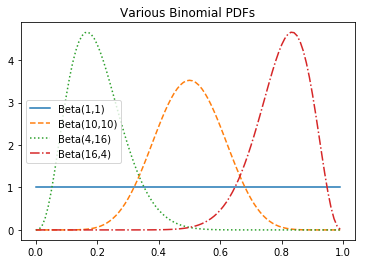

In [28]:
%matplotlib inline

#from collections import Counter
from matplotlib import pyplot as plt

# plot some PDFs
x_ax = [x/100 for x in range(0,100)]
plt.plot(x_ax, [beta_pdf(x,1,1) for x in x_ax], linestyle='-'
         ,label="Beta(1,1)")
plt.plot(x_ax, [beta_pdf(x,10,10) for x in x_ax], linestyle='--'
         ,label="Beta(10,10)")
plt.plot(x_ax, [beta_pdf(x,4,16) for x in x_ax], linestyle=':'
         ,label="Beta(4,16)")
plt.plot(x_ax, [beta_pdf(x,16,4) for x in x_ax], linestyle='-.'
         ,label="Beta(16,4)")
plt.legend()
plt.title("Various Binomial PDFs")
plt.show()

Let’s say we **assume a prior distribution on p**. Maybe we don’t want to take a stand on
whether the coin is fair, + we choose alpha and beta to both = 1. Or maybe we have
a strong belief it lands heads 55% of the time, and+we choose alpha = 55, beta = 45.

Then, we flip our coin a bunch of times + see `h` heads and `t` tails. Bayes’s Theorem (+ some tedious math) tells us that the posterior distribution for p is, again, a Beta distribution but with parameters **`alpha + h`** and **`beta + t`**

Let’s say we flip a coin 10 times + see only 3 heads. If we started w/ the uniform prior (in some sense refusing to take a stand about coin’s fairness), the posterior distribution would be a **`Beta(4, 8)`**, centered around 0.33. Since we considered all probabilities equally likely (uniform distribution), your best guess is something pretty close to the observed probability.

If you started w/ a **`Beta(20, 20)`** (expressing a belief the coin was roughly fair),
your posterior distribution would be a **`Beta(23, 27)`**, centered around 0.46, indicating a revised belief that maybe the coin is slightly biased toward tails.

And if you started with a **`Beta(30, 10`)** (expressing a belief the coin was biased to flip 75% heads), your posterior distribution would be a **`Beta(33, 17)`**, centered around 0.66. In that case you’d still believe in a heads bias, but less strongly than you did initially. 

These three different posteriors:

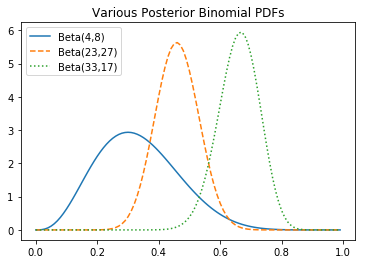

In [29]:
x_ax = [x/100 for x in range(0,100)]
x_ax = [x/100 for x in range(0,100)]
plt.plot(x_ax, [beta_pdf(x,4,8) for x in x_ax], linestyle='-'
         ,label="Beta(4,8)")
plt.plot(x_ax, [beta_pdf(x,23,27) for x in x_ax], linestyle='--'
         ,label="Beta(23,27)")
plt.plot(x_ax, [beta_pdf(x,33,17) for x in x_ax], linestyle=':'
         ,label="Beta(33,17)")
plt.legend()
plt.title("Various Posterior Binomial PDFs")
plt.show()

**If you flipped the coin more + more, the prior would matter less + less until eventually you’d have (nearly) the same posterior distribution no matter which prior you
started with.**

Ex: No matter how biased you initially thought the coin was, it would be hard to
maintain that belief after seeing 1000 heads out of 2000 flips. What’s interesting is that this allows us to make probability statements about hypotheses: *“Based on the prior + the observed data, there is only a 5% likelihood the coin’s heads probability is between 49% and 51%.”* 

This is philosophically very different from a statement like “if the coin were fair we would expect to observe data so extreme only 5% of the time.”

Using Bayesian inference to test hypotheses is considered somewhat controversial — in
part b/c its mathematics can get somewhat complicated, + in part b/c of the
subjective nature of choosing a prior.